<a href="https://colab.research.google.com/github/IbrahimAllMamun/flood_incidence/blob/main/flood_incidence.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf


from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, precision_recall_curve, confusion_matrix

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers, metrics, Input, Model


import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
!wget https://raw.githubusercontent.com/IbrahimAllMamun/flood_incidence/main/flood.csv

--2025-09-15 12:31:23--  https://raw.githubusercontent.com/IbrahimAllMamun/flood_incidence/main/flood.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2071590 (2.0M) [text/plain]
Saving to: ‘flood.csv’

flood.csv           100%[===================>]   1.98M  --.-KB/s    in 0.05s   

2025-09-15 12:31:24 (36.9 MB/s) - ‘flood.csv’ saved [2071590/2071590]



In [4]:
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
tf.random.set_seed(RANDOM_STATE)

In [5]:
df = pd.read_csv('flood.csv')
df.rename(columns={'Flood?':'Flood'}, inplace=True)
df = df.sort_values(["Year", "Month", "Station_Number"])
df.drop(columns=['Sl', 'LATITUDE', 'LONGITUDE', 'Period'], inplace=True)
df.fillna({'Flood':0}, inplace=True)
display(df.head())

,Station_Names,Year,Month,Max_Temp,Min_Temp,Rainfall,Relative_Humidity,Wind_Speed,Cloud_Coverage,Bright_Sunshine,Station_Number,X_COR,Y_COR,ALT,Flood
5892,Dinajpur,1948,1,28.9,10.4,0.000000,60.00000,0.624074,1.3,5.572000,41863,365790.2,834718.0,37,0.0
1356,Bogra,1948,1,25.8,11.7,8.140625,74.21875,0.875926,1.1,7.296226,41883,435303.7,751187.5,20,0.0
13188,Mymensingh,1948,1,28.3,11.7,0.000000,67.00000,0.594444,1.7,6.134286,41886,540975.3,737535.8,19,0.0
18288,Srimangal,1948,1,27.7,9.0,8.015385,75.00000,0.464815,2.4,6.710714,41915,675761.6,687095.9,23,0.0
6684,Faridpur,1948,1,27.8,11.9,3.000000,91.00000,0.746296,2.9,6.986207,41929,483877.3,610719.3,9,0.0


In [6]:
# df = df[df['Station_Names'] != "Chittagong (City-Ambagan)"]
# display(df.head())
# print(df.shape)

In [7]:
df.shape

(20544, 15)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20544 entries, 5892 to 20543
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Station_Names      20544 non-null  object 
 1   Year               20544 non-null  int64  
 2   Month              20544 non-null  int64  
 3   Max_Temp           20544 non-null  float64
 4   Min_Temp           20544 non-null  float64
 5   Rainfall           20544 non-null  float64
 6   Relative_Humidity  20544 non-null  float64
 7   Wind_Speed         20544 non-null  float64
 8   Cloud_Coverage     20544 non-null  float64
 9   Bright_Sunshine    20544 non-null  float64
 10  Station_Number     20544 non-null  int64  
 11  X_COR              20544 non-null  float64
 12  Y_COR              20544 non-null  float64
 13  ALT                20544 non-null  int64  
 14  Flood              20544 non-null  float64
dtypes: float64(10), int64(4), object(1)
memory usage: 2.5+ MB


In [9]:
df["Month_sin"] = np.sin(2 * np.pi * (df["Month"] - 1) / 12.0)
df["Month_cos"] = np.cos(2 * np.pi * (df["Month"] - 1) / 12.0)

In [10]:
df['Time'] = pd.to_datetime(df[['Year', 'Month']].assign(Day=1))
display(df.head())

,Station_Names,Year,Month,Max_Temp,Min_Temp,Rainfall,Relative_Humidity,Wind_Speed,Cloud_Coverage,Bright_Sunshine,Station_Number,X_COR,Y_COR,ALT,Flood,Month_sin,Month_cos,Time
5892,Dinajpur,1948,1,28.9,10.4,0.000000,60.00000,0.624074,1.3,5.572000,41863,365790.2,834718.0,37,0.0,0.0,1.0,1948-01-01
1356,Bogra,1948,1,25.8,11.7,8.140625,74.21875,0.875926,1.1,7.296226,41883,435303.7,751187.5,20,0.0,0.0,1.0,1948-01-01
13188,Mymensingh,1948,1,28.3,11.7,0.000000,67.00000,0.594444,1.7,6.134286,41886,540975.3,737535.8,19,0.0,0.0,1.0,1948-01-01
18288,Srimangal,1948,1,27.7,9.0,8.015385,75.00000,0.464815,2.4,6.710714,41915,675761.6,687095.9,23,0.0,0.0,1.0,1948-01-01
6684,Faridpur,1948,1,27.8,11.9,3.000000,91.00000,0.746296,2.9,6.986207,41929,483877.3,610719.3,9,0.0,0.0,1.0,1948-01-01


In [11]:
time_varying = [
    "Max_Temp", "Min_Temp", "Rainfall", "Relative_Humidity",
    "Wind_Speed", "Cloud_Coverage", "Bright_Sunshine",
    "Month_sin", "Month_cos"
]
static_feats = ["ALT", "X_COR", "Y_COR"]

In [12]:
def build_sequences_monthly(df, window=12):
    X_seq, X_static, y, groups = [], [], [], []

    for st, g in df.groupby("Station_Number"):
        g = g.sort_values(["Year", "Month"])   # continuous timeline per station

        seq_data = g[time_varying].to_numpy(dtype=float)
        static_vals = g[static_feats].iloc[0].to_numpy(dtype=float)
        labels = g["Flood"].to_numpy(dtype=int)
        years = g["Year"].to_numpy()
        months = g["Month"].to_numpy()

        for i in range(len(g) - window):
            X_seq.append(seq_data[i:i+window])
            X_static.append(static_vals)
            y.append(labels[i+window])  # predict flood in next month
            groups.append((st, years[i+window], months[i+window]))

    return (
        np.array(X_seq),
        np.array(X_static),
        np.array(y).astype(int),
        pd.DataFrame(groups, columns=["Station_Number", "Year", "Month"])
    )


# Example
X_seq, X_static, y, groups = build_sequences_monthly(df, window=12)
print("Sequences:", X_seq.shape)   # (N, 12, n_features)
print("Static:", X_static.shape)   # (N, 3)
print("Labels:", y.shape)          # (N,)
print("Positives:", y.sum(), "Negatives:", (y==0).sum())


Sequences: (20148, 12, 9)
Static: (20148, 3)
Labels: (20148,)
Positives: 4048 Negatives: 16100


In [13]:
groups

,Station_Number,Year,Month
0,41859,1955,1
1,41859,1955,2
2,41859,1955,3
3,41859,1955,4
4,41859,1955,5
...,...,...,...
20143,41998,2013,8
20144,41998,2013,9
20145,41998,2013,10
20146,41998,2013,11


In [14]:
from sklearn.model_selection import train_test_split

# Build sequences first
X_seq, X_static, y, groups = build_sequences_monthly(df, window=12)

# Choose cutoff year
cutoff_year_val = 2000
cutoff_year_test = 2008

train_idx = groups["Year"] <= cutoff_year_val
val_idx = (groups["Year"] > cutoff_year_val) & (groups["Year"] < cutoff_year_test)
test_idx  = groups["Year"] > cutoff_year_test

X_seq_train, X_seq_test, X_seq_val = X_seq[train_idx], X_seq[test_idx], X_seq[val_idx]
X_static_train, X_static_test, X_static_val = X_static[train_idx], X_static[test_idx], X_static[val_idx]
y_train, y_test, y_val = y[train_idx], y[test_idx], y[val_idx]
groups_train, groups_test, groups_val = groups[train_idx], groups[test_idx], groups[val_idx]

print("Train:", X_seq_train.shape, "Positives:", y_train.sum())
print("Test :", X_seq_test.shape, "Positives:", y_test.sum())
print("Test :", X_seq_val.shape, "Positives:", y_val.sum())


Train: (15120, 12, 9) Positives: 2970
Test : (1956, 12, 9) Positives: 397
Test : (2688, 12, 9) Positives: 605


In [15]:
seq_shape = X_seq_train.shape[1:]  # (12, Ft)

seq_imputer = SimpleImputer(strategy="median")
sta_imputer = SimpleImputer(strategy="median")

# fit on flattened time-varying train
Ntr, T, F = X_seq_train.shape
Xseq_tr_flat = X_seq_train.reshape(-1, F)
Xseq_tr_imp  = seq_imputer.fit_transform(Xseq_tr_flat)
Xseq_tr_imp  = Xseq_tr_imp.reshape(Ntr, T, F)

# impute others
def impute_seq(X):
    N, T, F = X.shape
    Xf = X.reshape(-1, F)
    Xf = seq_imputer.transform(Xf)
    return Xf.reshape(N, T, F)

Xseq_val_imp = impute_seq(X_seq_val)
Xseq_te_imp  = impute_seq(X_seq_test)

# static
Xs_tr_imp  = sta_imputer.fit_transform(X_static_train)
Xs_val_imp = sta_imputer.transform(X_static_val)
Xs_te_imp  = sta_imputer.transform(X_static_test)

# scale
seq_scaler = StandardScaler()
sta_scaler = StandardScaler()

Xseq_tr_s  = seq_scaler.fit_transform(Xseq_tr_imp.reshape(-1, F)).reshape(Ntr, T, F)
Xseq_val_s = seq_scaler.transform(Xseq_val_imp.reshape(-1, F)).reshape(X_seq_val.shape[0], T, F)
Xseq_te_s  = seq_scaler.transform(Xseq_te_imp.reshape(-1, F)).reshape(X_seq_test.shape[0], T, F)

Xs_tr_s  = sta_scaler.fit_transform(Xs_tr_imp)
Xs_val_s = sta_scaler.transform(Xs_val_imp)
Xs_te_s  = sta_scaler.transform(Xs_te_imp)


In [16]:
print("Sequences:", X_seq_train.shape)   # (N, 12, n_features)
print("Static:", X_static_train.shape)   # (N, 3)
print("Labels:", y_train.shape)          # (N,)
print("Positives:", y_train.sum(), "Negatives:", (y_train==0).sum())

Sequences: (15120, 12, 9)
Static: (15120, 3)
Labels: (15120,)
Positives: 2970 Negatives: 12150


In [17]:
X_seq, X_static, y, groups = build_sequences_monthly(df, window=12)
print("Sequences:", Xseq_tr_s.shape)   # (N, 12, n_features)
print("Static:", Xs_tr_s.shape)   # (N, 3)


Sequences: (15120, 12, 9)
Static: (15120, 3)


In [54]:
def make_model(n_steps, n_seq_feats, n_static_feats, lstm_units=(64, 32), dense_units=32, dropout=0.2, lr=1e-3):
    seq_in = Input(shape=(n_steps, n_seq_feats), name="seq_in")
    x = seq_in
    # LSTM stack
    x = layers.LSTM(lstm_units[0], return_sequences=True)(x)
    x = layers.Dropout(dropout)(x)
    x = layers.LSTM(lstm_units[1])(x)
    x = layers.Dropout(dropout)(x)

    inputs = [seq_in]
    # static tower
    if n_static_feats > 0:
        sta_in = Input(shape=(n_static_feats,), name="static_in")
        s = layers.Dense(32, activation="tanh")(sta_in)
        s = layers.Dense(32, activation="tanh")(s)
        s = layers.Dropout(dropout)(s)
        x = layers.Concatenate()([x, s])
        inputs.append(sta_in)

    x = layers.Dense(dense_units, activation="relu")(x)
    out = layers.Dense(1, activation="sigmoid", name="out")(x)

    model = Model(inputs=inputs, outputs=out)
    model.compile(
        optimizer=optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=[
            metrics.AUC(curve="ROC", name="auc_roc"),
            metrics.AUC(curve="PR",  name="auc_pr"),
            metrics.Precision(name="precision"),
            metrics.Recall(name="recall"),
            metrics.BinaryAccuracy(name="accuracy", threshold=0.5)
        ],
    )

    return model

model = make_model(
    n_steps=T,
    n_seq_feats=F,
    n_static_feats=Xs_tr_s.shape[1],
    lstm_units=(64, 32),
    dense_units=32,
    dropout=0.3,
    lr=1e-4
)

model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ seq_in (InputLayer) │ (None, 12, 9)     │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_18 (LSTM)      │ (None, 12, 64)    │     18,944 │ seq_in[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ static_in           │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_27          │ (None, 12, 64)    │          0 │ lstm_18[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_33 (Dense)    │ (None, 32)        │        128 │ static_in[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_19 (LSTM)      │ (None, 32)        │     12,416 │ dropout_27[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_34 (Dense)    │ (None, 32)        │      1,056 │ dense_33[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_28          │ (None, 32)        │          0 │ lstm_19[0][0]     │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_29          │ (None, 32)        │          0 │ dense_34[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_9       │ (None, 64)        │          0 │ dropout_28[0][0], │
│ (Concatenate)       │                   │            │ dropout_29[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_35 (Dense)    │ (None, 32)        │      2,080 │ concatenate_9[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ out (Dense)         │ (None, 1)         │         33 │ dense_35[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 34,657 (135.38 KB)

 Trainable params: 34,657 (135.38 KB)

 Non-trainable params: 0 (0.00 B)

In [49]:
# -----------------------
# 7) Class weights for imbalance
# -----------------------
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
pos_weight = neg / max(pos, 1)
class_weight = {0: 1.0, 1: float(pos_weight)}
print("Class weights:", class_weight)

Class weights: {0: 1.0, 1: 4.090909090909091}


In [55]:
# -----------------------
# 8) Train
# -----------------------
es = callbacks.EarlyStopping(
    monitor="val_accuracy", # Changed monitor to val_accuracy
    mode="max",
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    x=[Xseq_tr_s, Xs_tr_s],
    y=y_train,
    validation_data=([Xseq_val_s, Xs_val_s], y_val),
    epochs=200,
    batch_size=128,
    class_weight=class_weight,
    callbacks=[es],
    verbose=1,
)

Epoch 1/200
119/119 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - accuracy: 0.5029 - auc_pr: 0.2435 - auc_roc: 0.5808 - loss: 1.0946 - precision: 0.2274 - recall: 0.6633 - val_accuracy: 0.7065 - val_auc_pr: 0.6121 - val_auc_roc: 0.8477 - val_loss: 0.6319 - val_precision: 0.4257 - val_recall: 0.8711
Epoch 2/200
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - accuracy: 0.6981 - auc_pr: 0.5377 - auc_roc: 0.8473 - loss: 0.9279 - precision: 0.3804 - recall: 0.8937 - val_accuracy: 0.8121 - val_auc_pr: 0.6782 - val_auc_roc: 0.8962 - val_loss: 0.4202 - val_precision: 0.5541 - val_recall: 0.8463
Epoch 3/200
119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.7842 - auc_pr: 0.6100 - auc_roc: 0.8947 - loss: 0.6596 - precision: 0.4676 - recall: 0.8909 - val_accuracy: 0.8073 - val_auc_pr: 0.7023 - val_auc_roc: 0.9010 - val_loss: 0.3806 - val_precision: 0.5463 - val_recall: 0.8479
Epoch 4/200
119/119 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - accuracy: 0.7900 - auc_pr: 0.6435 - auc_roc: 0.9052 - loss: 0.6000 - prec

In [56]:
# -----------------------
# 9) Threshold tuning on validation
# -----------------------
val_probs = model.predict([Xseq_val_s, Xs_val_s]).ravel()
prec, rec, thr = precision_recall_curve(y_val, val_probs)
f1 = 2 * prec * rec / (prec + rec + 1e-9)
best_idx = np.nanargmax(f1)
best_thr = thr[best_idx] if best_idx < len(thr) else 0.5
print("Best threshold (F1 on val):", best_thr)



84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Best threshold (F1 on val): 0.499079


In [57]:
# -----------------------
# 10) Final evaluation on test
# -----------------------
from sklearn.metrics import accuracy_score

test_probs = model.predict([Xseq_te_s, Xs_te_s]).ravel()
test_pred  = (test_probs >= best_thr).astype(int)

print("ROC-AUC:", roc_auc_score(y_test, test_probs))
print("PR-AUC:",  average_precision_score(y_test, test_probs))
print("Accuracy:", accuracy_score(y_test, test_pred))
print("Confusion matrix:\n", confusion_matrix(y_test, test_pred))
print(classification_report(y_test, test_pred, digits=3))

62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
ROC-AUC: 0.8868954619556876
PR-AUC: 0.6515690084706441
Accuracy: 0.810838445807771
Confusion matrix:
 [[1278  281]
 [  89  308]]
              precision    recall  f1-score   support

           0      0.935     0.820     0.874      1559
           1      0.523     0.776     0.625       397

    accuracy                          0.811      1956
   macro avg      0.729     0.798     0.749      1956
weighted avg      0.851     0.811     0.823      1956



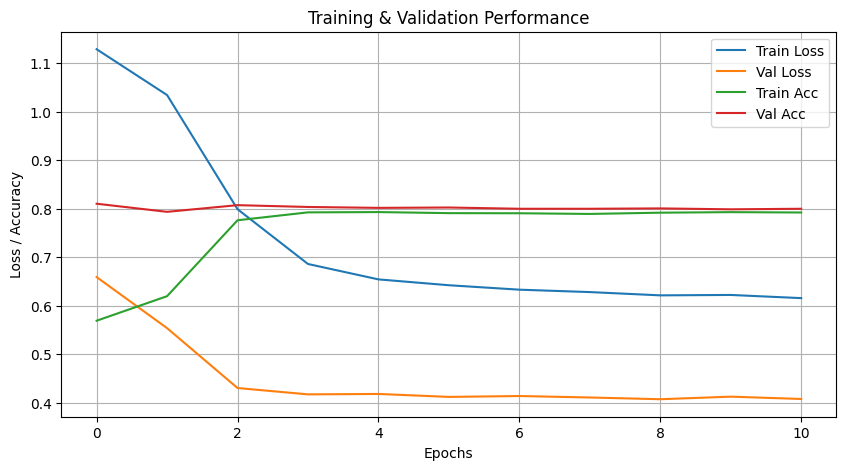

In [53]:
# -----------------------
# 9) Plot Training Curves
# -----------------------
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))

# Plot loss
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")

# Optional: add accuracy or AUC
if "accuracy" in history.history:
    plt.plot(history.history["accuracy"], label="Train Acc")
if "val_accuracy" in history.history:
    plt.plot(history.history["val_accuracy"], label="Val Acc")

plt.xlabel("Epochs")
plt.ylabel("Loss / Accuracy")
plt.title("Training & Validation Performance")
plt.legend()
plt.grid(True)
plt.show()

```
model = make_model(
    n_steps=T,
    n_seq_feats=F,
    n_static_feats=Xs_tr_s.shape[1],
    lstm_units=(64, 32),
    dense_units=32,
    dropout=0.3,
    lr=1e-3
)

# -----------------------
# 8) Train
# -----------------------
es = callbacks.EarlyStopping(
    monitor="val_accuracy", # Changed monitor to val_accuracy
    mode="max",
    patience=10,
    restore_best_weights=True
)

history = model.fit(
    x=[Xseq_tr_s, Xs_tr_s],
    y=y_train,
    validation_data=([Xseq_val_s, Xs_val_s], y_val),
    epochs=200,
    batch_size=128,
    class_weight=class_weight,
    callbacks=[es],
    verbose=1,
)



Best threshold (F1 on val): 0.71895254

ROC-AUC: 0.9160089381070019
PR-AUC: 0.7394622780049686
Accuracy: 0.864519427402863
Confusion matrix:
 [[1401  158]
 [ 107  290]]
              precision    recall  f1-score   support

           0      0.929     0.899     0.914      1559
           1      0.647     0.730     0.686       397

    accuracy                          0.865      1956
   macro avg      0.788     0.815     0.800      1956
weighted avg      0.872     0.865     0.867      1956
```